Analytical steady (tilde frame):
<sigma->_ss = (-0.12091898428053205-0.006045949214026602j)
<sigma+>_ss = (-0.12091898428053205+0.006045949214026602j)
<sigma_z>_ss = -0.9697702539298669
Numerical at t=T: [-0.12091898-6.04594905e-03j -0.12091898+6.04594905e-03j
 -0.96977025+7.25910605e-31j]


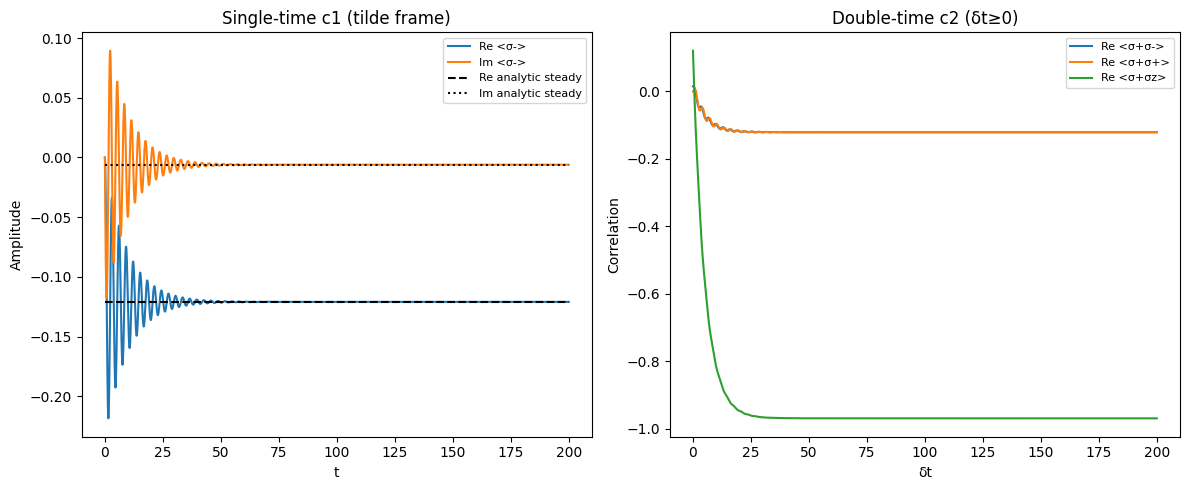

   delta_t  Re<σ+σ->  Re<σ+σ+>  Re<σ+σz>
0      0.0  0.015115  0.000000  0.120919
1     20.0 -0.118795 -0.116928 -0.947461
2     40.0 -0.120711 -0.120904 -0.969341
3     60.0 -0.120943 -0.120927 -0.969752
4     80.0 -0.120916 -0.120916 -0.969772


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

#Parameters 
tau = 10.0
k = 2.0
D = 20.0
omegaR = 0.5
R = omegaR * tau
phi = 0.0
Omega = k + D / tau
Omega_tilde = Omega - k

def M_matrix(tau, Omega_tilde, omegaR, phi):
    m11 = -(1.0/tau + 1j * Omega_tilde)
    m12 = 0.0
    m13 = 1j * omegaR / 2.0 * np.exp(1j * phi)
    m21 = 0.0
    m22 = -(1.0/tau - 1j * Omega_tilde)
    m23 = -1j * omegaR / 2.0 * np.exp(-1j * phi)
    m31 = 1j * omegaR * np.exp(-1j * phi)
    m32 = -1j * omegaR * np.exp(1j * phi)
    m33 = -2.0 / tau
    M = np.array([[m11, m12, m13],
                  [m21, m22, m23],
                  [m31, m32, m33]], dtype=complex)
    return M

M = M_matrix(tau, Omega_tilde, omegaR, phi)
b1 = np.array([0.0+0j, 0.0+0j, -2.0/tau + 0j])

# initial ground state
c1_0 = np.array([0.0+0j, 0.0+0j, -1.0+0j])

#convert complex system to real for solve_ivp
def odes_real(t, y):
    n = len(y)//2
    y_complex = y[:n] + 1j*y[n:]
    dydt_complex = M.dot(y_complex) + b1
    return np.concatenate([dydt_complex.real, dydt_complex.imag])

y0 = np.concatenate([c1_0.real, c1_0.imag])
T = 200.0
t_eval = np.linspace(0, T, 2001)
sol = solve_ivp(odes_real, [0, T], y0, t_eval=t_eval, rtol=1e-9, atol=1e-12)
n = 3
c1_t = sol.y[:n, :] + 1j * sol.y[n:, :]

#analytical steady state (B5/B6)
den = 1.0 + D**2 + 0.5 * R**2
sigma_minus_ss = -1j * 0.5 * R * (1 - 1j * D) / den
sigma_plus_ss = 1j * 0.5 * R * (1 + 1j * D) / den
sigma_z_ss = -1.0 + (R**2) / (2.0 * den)

print("Analytical steady (tilde frame):")
print("<sigma->_ss =", sigma_minus_ss)
print("<sigma+>_ss =", sigma_plus_ss)
print("<sigma_z>_ss =", sigma_z_ss)
print("Numerical at t=T:", c1_t[:, -1])

#double-time correlations: initial at delta=0 (steady-state)
c2_0 = np.array([0.25 * R**2 / den, 0.0+0j, -sigma_plus_ss])
b2 = np.array([0.0+0j, 0.0+0j, -2.0/tau * sigma_plus_ss])

y0_c2 = np.concatenate([c2_0.real, c2_0.imag])
sol2 = solve_ivp(odes_real, [0, T], y0_c2, t_eval=t_eval, rtol=1e-9, atol=1e-12)
c2_t = sol2.y[:n, :] + 1j * sol2.y[n:, :]

#plotting
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(sol.t, c1_t[0].real, label='Re <σ->')
plt.plot(sol.t, c1_t[0].imag, label='Im <σ->')
plt.hlines(sigma_minus_ss.real, 0, T, colors='k', linestyles='--', label='Re analytic steady')
plt.hlines(sigma_minus_ss.imag, 0, T, colors='k', linestyles=':', label='Im analytic steady')
plt.xlabel('t'); plt.ylabel('Amplitude'); plt.title('Single-time c1 (tilde frame)')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.plot(sol2.t, c2_t[0].real, label='Re <σ+σ->')
plt.plot(sol2.t, c2_t[1].real, label='Re <σ+σ+>')
plt.plot(sol2.t, c2_t[2].real, label='Re <σ+σz>')
plt.xlabel('δt'); plt.ylabel('Correlation'); plt.title('Double-time c2 (δt≥0)')
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

#print small c2 sample
df = pd.DataFrame({
    "delta_t": sol2.t[::200],
    "Re<σ+σ->": c2_t[0, ::200].real,
    "Re<σ+σ+>": c2_t[1, ::200].real,
    "Re<σ+σz>": c2_t[2, ::200].real
})
print(df.head())


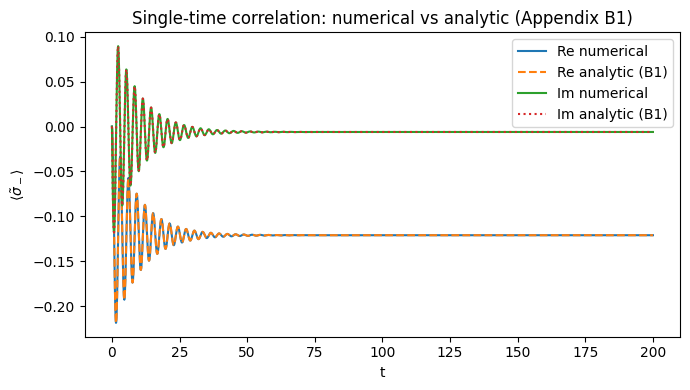

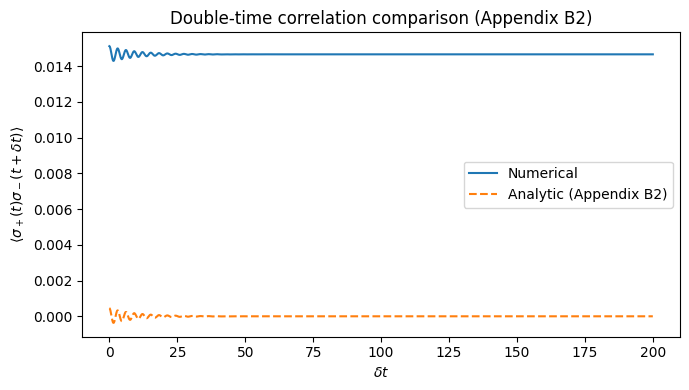

Steady-state comparison:
Analytic <σ->: (-0.12091898428053205-0.006045949214026602j)
Numeric  <σ->: (-0.12091898436690515-0.006045949053760382j)


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#parameters 
tau = 10.0
k = 2.0
D = 20.0
omegaR = 0.5
phi = 0.0

Omega = k + D / tau
Omega_tilde = Omega - k
R = omegaR * tau

#Bloch matrix (appendix c) 
def M_matrix(tau, Omega_tilde, omegaR, phi):
    return np.array([
        [-(1/tau + 1j*Omega_tilde), 0.0,  1j*omegaR/2*np.exp(1j*phi)],
        [0.0, -(1/tau - 1j*Omega_tilde), -1j*omegaR/2*np.exp(-1j*phi)],
        [1j*omegaR*np.exp(-1j*phi), -1j*omegaR*np.exp(1j*phi), -2/tau]
    ], dtype=complex)

M = M_matrix(tau, Omega_tilde, omegaR, phi)

#Steady State (B5/B6) 
den = 1 + D**2 + 0.5*R**2
sigma_minus_ss = -1j * 0.5*R*(1 - 1j*D)/den
sigma_plus_ss  =  1j * 0.5*R*(1 + 1j*D)/den
sigma_z_ss     = -1 + R**2/(2*den)

#Single-time numerics 
b1 = np.array([0, 0, -2/tau], dtype=complex)
c1_0 = np.array([0, 0, -1], dtype=complex)

def odes_real(t, y, b):
    n = len(y)//2
    y_c = y[:n] + 1j*y[n:]
    dydt = M @ y_c + b
    return np.concatenate([dydt.real, dydt.imag])

T = 200
t_eval = np.linspace(0, T, 2001)

y0 = np.concatenate([c1_0.real, c1_0.imag])
sol = solve_ivp(lambda t,y: odes_real(t,y,b1),
                [0,T], y0, t_eval=t_eval,
                rtol=1e-9, atol=1e-12)

c1_t = sol.y[:3] + 1j*sol.y[3:]

#Analytic b1/b2 eigenmodes
eigvals, eigvecs = np.linalg.eig(M)
Vinv = np.linalg.inv(eigvecs)

c_ss = np.array([sigma_minus_ss, sigma_plus_ss, sigma_z_ss])
A = Vinv @ (c1_0 - c_ss)

sigma_minus_analytic = np.zeros_like(sol.t, dtype=complex)
for j in range(3):
    sigma_minus_analytic += A[j] * eigvecs[0,j] * np.exp(eigvals[j]*sol.t)
sigma_minus_analytic += sigma_minus_ss

#Single-time plot (b1/b2) 
plt.figure(figsize=(7,4))
plt.plot(sol.t, c1_t[0].real, label='Re numerical')
plt.plot(sol.t, sigma_minus_analytic.real, '--', label='Re analytic (B1)')
plt.plot(sol.t, c1_t[0].imag, label='Im numerical')
plt.plot(sol.t, sigma_minus_analytic.imag, ':', label='Im analytic (B1)')
plt.xlabel('t')
plt.ylabel(r'$\langle \tilde{\sigma}_- \rangle$')
plt.legend()
plt.title('Single-time correlation: numerical vs analytic (Appendix B1)')
plt.tight_layout()
plt.show()

#double-time (qrt) numerics 
c2_0 = np.array([
    0.5*(1 + sigma_z_ss),
    0.0,
    -sigma_plus_ss
], dtype=complex)

b2 = np.array([0, 0, -2/tau * sigma_plus_ss], dtype=complex)

y0_c2 = np.concatenate([c2_0.real, c2_0.imag])

sol2 = solve_ivp(lambda t,y: odes_real(t,y,b2),
                 [0,T], y0_c2, t_eval=t_eval,
                 rtol=1e-9, atol=1e-12)

c2_t = sol2.y[:3] + 1j*sol2.y[3:]

# analytic c2 (appendix b2)
A2 = Vinv @ (c2_0 - (-np.linalg.solve(M, b2)))

c2_analytic = np.zeros_like(sol2.t, dtype=complex)
for j in range(3):
    c2_analytic += A2[j] * eigvecs[0,j] * np.exp(eigvals[j]*sol2.t)

#Double time comparison plot
plt.figure(figsize=(7,4))
plt.plot(sol2.t, c2_t[0].real, label='Numerical')
plt.plot(sol2.t, c2_analytic.real, '--', label='Analytic (Appendix B2)')
plt.xlabel(r'$\delta t$')
plt.ylabel(r'$\langle \sigma_+(t)\sigma_-(t+\delta t) \rangle$')
plt.legend()
plt.title('Double-time correlation comparison (Appendix B2)')
plt.tight_layout()
plt.show()

#Final Check
print("Steady-state comparison:")
print("Analytic <σ->:", sigma_minus_ss)
print("Numeric  <σ->:", c1_t[0,-1])


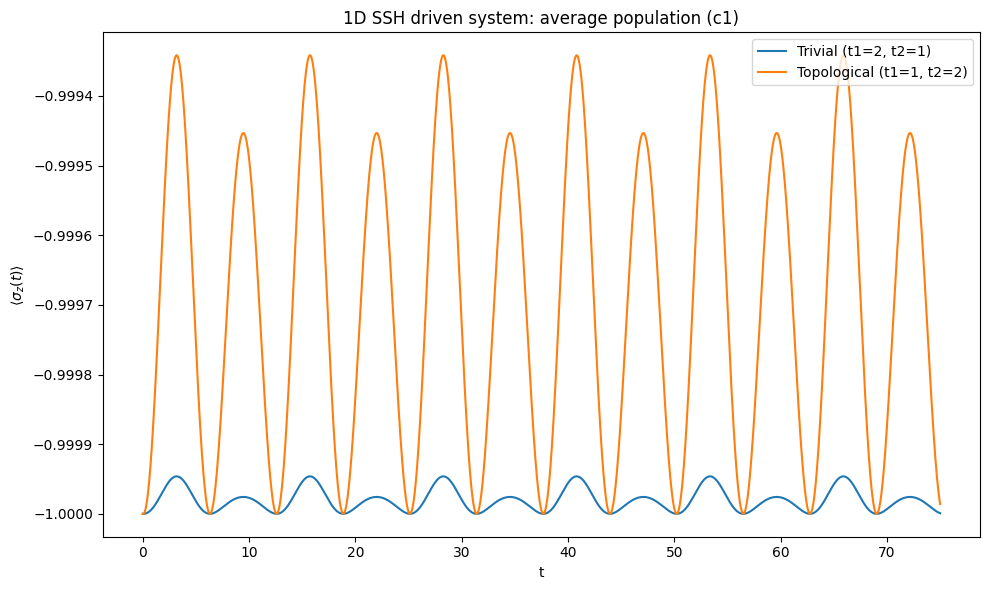

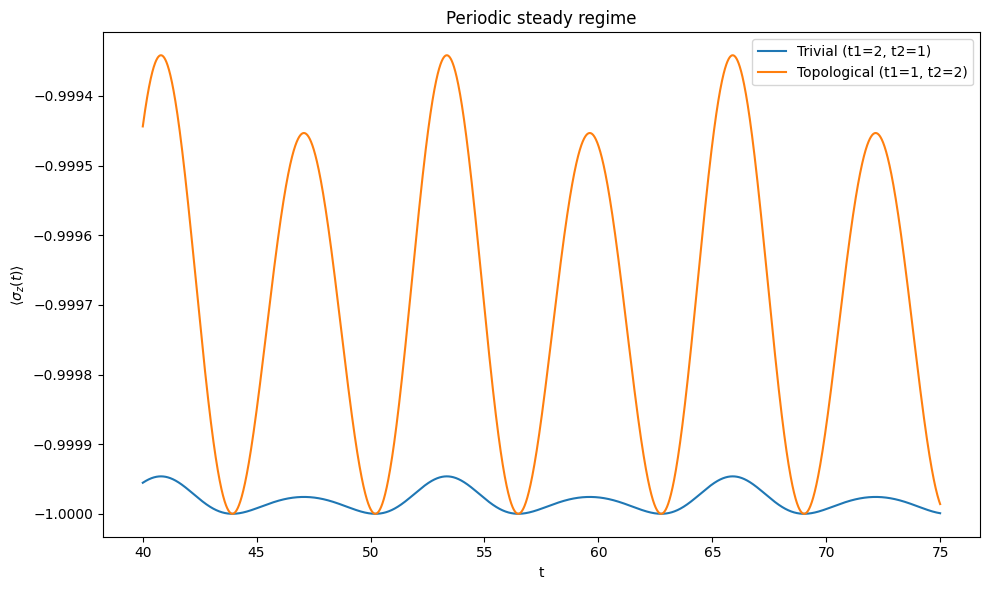

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#parameters
tau = 0.05
k = np.pi / 2

A0 = 0.2
omega = 0.501

Tmax = 75.0
dt = 0.01
t_eval = np.arange(0, Tmax, dt)

#SSH model definitions
def E_plus(k, t1, t2):
    return np.sqrt(t1**2 + t2**2 + 2*t1*t2*np.cos(k))

def dE_dk(k, t1, t2):
    return -(t1*t2*np.sin(k)) / E_plus(k, t1, t2)

def A_pp(k, t1, t2):
    num = t2 * (t2 + t1*np.cos(k))
    den = 2*(t1**2 + t2**2 + 2*t1*t2*np.cos(k))
    return num / den

def A_t(t):
    return A0 * np.sin(omega * t)

#time-dependent fields hz, hy
def hz_k(t, k, t1, t2):
    Ep = E_plus(k, t1, t2)
    dEdk = dE_dk(k, t1, t2)
    App = A_pp(k, t1, t2)
    At = A_t(t)
    return Ep - dEdk*np.sin(At) - 2*Ep*App*(1 - np.cos(At))

def hy_k(t, k, t1, t2):
    Ep = E_plus(k, t1, t2)
    dEdk = dE_dk(k, t1, t2)
    App = A_pp(k, t1, t2)
    At = A_t(t)
    return dEdk*(1 - np.cos(At)) - 2*Ep*App*np.sin(At)

#Bloch matrix B(k,t)
def B_matrix(t, k, t1, t2):
    hz = hz_k(t, k, t1, t2)
    hy = hy_k(t, k, t1, t2)

    return np.array([
        [-(1/tau + 2j*hz),      0.0,          hy],
        [0.0,          -(1/tau - 2j*hz),      hy],
        [-2*hy,         -2*hy,       -2/tau]
    ], dtype=complex)

b1 = np.array([0.0, 0.0, -2/tau], dtype=complex)

# real-valued ODE wrapper
def odes_real(t, y, k, t1, t2):
    n = len(y)//2
    y_c = y[:n] + 1j*y[n:]
    dydt = B_matrix(t, k, t1, t2) @ y_c + b1
    return np.concatenate([dydt.real, dydt.imag])

#initial condition (ground state)
c1_0 = np.array([0.0, 0.0, -1.0], dtype=complex)
y0 = np.concatenate([c1_0.real, c1_0.imag])

#run for trivial and topological phases
cases = {
    "Trivial (t1=2, t2=1)": (2.0, 1.0),
    "Topological (t1=1, t2=2)": (1.0, 2.0)
}

results = {}

for label, (t1, t2) in cases.items():
    sol = solve_ivp(
        odes_real,
        [0, Tmax],
        y0,
        t_eval=t_eval,
        args=(k, t1, t2),
        rtol=1e-8,
        atol=1e-10
    )

    c1_t = sol.y[:3] + 1j*sol.y[3:]
    results[label] = c1_t

#Plot results (periodic regime)
plt.figure(figsize=(10,6))

for label, c1_t in results.items():
    plt.plot(t_eval, c1_t[2].real, label=label)

plt.xlabel("t")
plt.ylabel(r"$\langle \sigma_z(t) \rangle$")
plt.title("1D SSH driven system: average population (c1)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
mask = t_eval > 40  # discard transient

for label, c1_t in results.items():
    plt.plot(t_eval[mask], c1_t[2, mask].real, label=label)

plt.xlabel("t")
plt.ylabel(r"$\langle \sigma_z(t) \rangle$")
plt.title("Periodic steady regime")
plt.legend()
plt.tight_layout()
plt.show()

